Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 [astropy.io.fits.verify]


hoho
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (290.60960111, 14.2883225)>


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(1, 1, 4096, 4096) (4096, 4096) (4096, 4096)
RA---SIN


'\n\n\noutfn = "RGB_90cm_CO_ATLASGAL.png"\nim = PIL.Image.fromarray((rgb_crop*255).astype(\'uint8\')[::-1,:])\nim.save(outfn)\navm.embed(outfn, outfn)\n\npl.figure(1).clf()\npl.imshow(im)\n\npl.matplotlib.rc_file(\'pubfiguresrc\')\n\npl.figure(2).clf()\nFF = aplpy.FITSFigure(outfn, figure=pl.figure(2))\nFF.show_rgb(outfn)\nFF.set_tick_labels_format(\'dd.d\',\'dd.d\')\nFF.save(\'aplpy_\'+outfn)\n\nFF.add_scalebar(((10*u.pc)/(5.1*u.kpc)*u.radian).to(u.deg).value)\nFF.scalebar.set_label("10 pc")\nFF.scalebar.set_font_size(18)\nFF.scalebar.set_font_weight(\'bold\')\nFF.scalebar.set_color(\'w\')\nFF.scalebar.set_linewidth(3)\nFF.save(\'aplpy_scalebar_\'+outfn)\n'

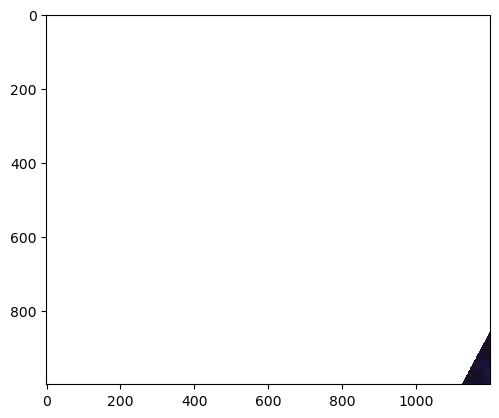

In [1]:
import pyavm
from astropy import units as u
#import aplpy
import numpy as np
#import copy
#import matplotlib
from astropy.io import fits
from astropy import wcs
import reproject
#import pylab as pl
#import PIL
#from PIL import ImageEnhance
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.coordinates import SkyCoord

b1 = fits.open('AG-Laboca-Planck.49.5.fits')
b2 = fits.open('W51_90cm_CDBB.fits')[0]
b3 = fits.open('grs_13CO_max_30to90kms.fits')
hdr = fits.Header.fromtextfile('hdr_new.hdr')
print('hoho')

#b1d,_ = reproject.reproject_interp(b1, hdr)
#b2d,_ = reproject.reproject_interp((b2.data, wcs.WCS(b2.header).celestial), hdr)
#b3d,_ = reproject.reproject_interp(b3, hdr)


b1d,_ = reproject.reproject_interp(b1, hdr)
b2d,_ = reproject.reproject_interp((b2.data, wcs.WCS(b2.header).celestial), hdr)
b3d,_ = reproject.reproject_interp(b3, hdr)

print(b1d)

def linearize(x, xmin=None, xmax=None, truncate=True):
    if np.isscalar(x):
        return x
    else:
        if xmin is None:
            xmin = np.nanmin(x)
        if xmax is None:
            xmax = np.nanmax(x)
        if truncate:
            x = np.copy(x)
            x[x<xmin] = xmin
            x[x>xmax] = xmax
        return ((x-xmin)/(xmax-xmin))

def logscale(arr, logexp=3.0, toint=True, relinearize=True, **kwargs):
    linarr = linearize(arr, **kwargs)
    if logexp is None:
        logarr = linarr
    else:
        logarr = np.log10(linarr * 10**logexp + 1)
    if relinearize:
        return linearize(logarr)
    elif toint:
        lla = linearize(logarr)*255
        return lla.astype('uint8')
    else:
        return logarr

def expscale(arr, exp=2, toint=True, **kwargs):
    linarr = linearize(arr, **kwargs)
    if toint:
        lla = linearize(linarr**exp)*255
        return lla.astype('uint8')
    else:
        return linarr**exp


red = linearize(b2d, xmin=-0.05, xmax=0.2) * 0.75 + linearize(b2d, xmin=0.2, xmax=0.7)*0.25
#red = linearize(b2d, xmin=0.01, xmax=0.2)
green = (linearize(b3d, 0, 7))
blue = linearize(b1d,0,0.5) * 0.5 + logscale(b1d, xmin=0.5, xmax=50, toint=False)*0.5
#blue = logscale(b1d, xmin=0.10, xmax=10, toint=False)
print(red.shape, green.shape, blue.shape)
rgb = np.array([red[0][0],green,blue]).T.swapaxes(0,1)
slices = slice(300,1300), slice(400,1600), slice(None) #[300:1300,400:1600]
rgb_crop = rgb[slices]

mywcs = wcs.WCS(hdr)[slices[:2]]
#avm = pyavm.AVM.from_wcs(mywcs)
hdr = mywcs.to_header()
plt.imshow(rgb_crop)
print(hdr["CTYPE1"])

hdu = fits.PrimaryHDU(data=rgb_crop, header=hdr)
hdul = fits.HDUList([hdu])
hdul.writeto('w51_rgb.fits', overwrite=True)




"""


outfn = "RGB_90cm_CO_ATLASGAL.png"
im = PIL.Image.fromarray((rgb_crop*255).astype('uint8')[::-1,:])
im.save(outfn)
avm.embed(outfn, outfn)

pl.figure(1).clf()
pl.imshow(im)

pl.matplotlib.rc_file('pubfiguresrc')

pl.figure(2).clf()
FF = aplpy.FITSFigure(outfn, figure=pl.figure(2))
FF.show_rgb(outfn)
FF.set_tick_labels_format('dd.d','dd.d')
FF.save('aplpy_'+outfn)

FF.add_scalebar(((10*u.pc)/(5.1*u.kpc)*u.radian).to(u.deg).value)
FF.scalebar.set_label("10 pc")
FF.scalebar.set_font_size(18)
FF.scalebar.set_font_weight('bold')
FF.scalebar.set_color('w')
FF.scalebar.set_linewidth(3)
FF.save('aplpy_scalebar_'+outfn)
"""

In [2]:
#